Here let's experiemnt with plotting graph with counterfactual prompts

In [1]:
import sys
sys.path.append('./')
sys.path.append('../')

from interventions import three_operands

from transformers import AutoTokenizer, AutoModelForCausalLM
from omegaconf import DictConfig, OmegaConf
from tqdm.notebook import tqdm
import torch
import random
import yaml
import numpy as np
import copy

from llm_transparency_tool.models.tlens_model import TransformerLensTransparentLlm
from llm_transparency_tool.models.transparent_llm import ModelInfo
from llm_transparency_tool.routes.graph import GraphBuilder, build_full_graph, build_paths_to_predictions
import networkx as nx

import matplotlib.pyplot as plt
import warnings

from utils.number_utils import convert_to_words

%matplotlib inline

In [2]:
seed = 0
random.seed(seed)
torch.manual_seed(seed)
torch.set_grad_enabled(False)

In [3]:
# model_name = 'EleutherAI/pythia-12b-deduped-v0'
# model_name_lens = 'pythia-12b-deduped-v0'
# model_name = 'EleutherAI/pythia-6.9b-deduped-v0'
# model_name_lens = 'pythia-6.9b-deduped-v0'
# model_name = 'facebook/opt-1.3b'
# model_name_lens = 'opt-1.3b'
# model_name = 'openai-community/gpt2'
# model_name_lens = 'gpt2'
# model_name = 'facebook/opt-6.7b'
# model_name_lens = 'opt-6.7b'
model_name = 'facebook/opt-2.7b'
model_name_lens = 'opt-2.7b'
# model_name = 'facebook/opt-13b'
# model_name_lens = 'opt-13b'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

/home/scratch_local/esx208-874251/ir_mech_interp/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Let's check that the tokenizer of OPT encodes symbols propelry

In [4]:
if 'facebook/opt' in model_name:
    SYMBOLS = ["alpha", "beta", "lambda", "delta", "omega", "mu", "nu", "pi", "chi", "number", "res", "x", "y", "z", "a", "b", "c"]
    WORD_NUMBERS = [
        "zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine",
        "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen", "sixteen", "seventeen", "eighteen", "nineteen", "twenty"
    ]
elif 'EleutherAI/pythia' in model_name:
    SYMBOLS = ["alpha", "beta", "gamma", "delta", "mu", "nu", "chi", "theta", "sigma", "number", "res", "x", "y", "z", "a", "b", "c"]
    WORD_NUMBERS = [
        "zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine",
        "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen", "sixteen", "seventeen", "eighteen", "nineteen", "twenty"
    ]
    
for item in SYMBOLS:
    print(tokenizer.tokenize(' ' + item))
print('#' * 10)
for item in WORD_NUMBERS:
    print(tokenizer.tokenize(' ' + item))

['Ġalpha']
['Ġbeta']
['Ġlambda']
['Ġdelta']
['Ġomega']
['Ġmu']
['Ġnu']
['Ġpi']
['Ġchi']
['Ġnumber']
['Ġres']
['Ġx']
['Ġy']
['Ġz']
['Ġa']
['Ġb']
['Ġc']
##########
['Ġzero']
['Ġone']
['Ġtwo']
['Ġthree']
['Ġfour']
['Ġfive']
['Ġsix']
['Ġseven']
['Ġeight']
['Ġnine']
['Ġten']
['Ġeleven']
['Ġtwelve']
['Ġthirteen']
['Ġfourteen']
['Ġfifteen']
['Ġsixteen']
['Ġseventeen']
['Ġeighteen']
['Ġnineteen']
['Ġtwenty']


In [5]:
conf = OmegaConf.load('./conf/config.yaml')
conf.model = model_name
conf.max_n = 20
intervention_list = three_operands.get_arithmetic_data_three_operands(tokenizer, conf)

 43%|████████████████████████████████████████▎                                                    | 91/210 [00:00<00:00, 857.20it/s]

res base: 14
res base wo whitespace: 4
res base with prefix: a 14
res base tok: ['a', 'Ġ14']
operands_base:  ('3', '5', '6')
base string tok list:  [306, 2055, 204, 2055, 231, 5457, 501, 4, 155, 2055, 195, 2055, 231, 5457]
z_base_tok:  231
y_base_tok:  195
x_base_tok:  155
res base: 17
res base wo whitespace: 7
res base with prefix: a 17
res base tok: ['a', 'Ġ17']
operands_base:  ('3', '7', '7')
base string tok list:  [246, 2055, 132, 2055, 290, 5457, 508, 4, 155, 2055, 262, 2055, 262, 5457]
z_base_tok:  262
y_base_tok:  262
x_base_tok:  155
res base: 12
res base wo whitespace: 2
res base with prefix: a 12
res base tok: ['a', 'Ġ12']
operands_base:  ('8', '2', '2')
base string tok list:  [306, 2055, 132, 2055, 290, 5457, 501, 4, 290, 2055, 132, 2055, 132, 5457]
z_base_tok:  132
y_base_tok:  132
x_base_tok:  290
res base: 14
res base wo whitespace: 4
res base with prefix: a 14
res base tok: ['a', 'Ġ14']
operands_base:  ('2', '6', '6')
base string tok list:  [698, 2055, 132, 2055, 155, 54

 84%|█████████████████████████████████████████████████████████████████████████████▌              | 177/210 [00:01<00:00, 123.77it/s]

res base: 18
res base wo whitespace: 8
res base with prefix: a 18
res base tok: ['a', 'Ġ18']
operands_base:  ('2', '3', '3')
base string tok list:  [176, 1009, 132, 1009, 155, 5457, 316, 4, 132, 1009, 155, 1009, 155, 5457]
z_base_tok:  155
y_base_tok:  155
x_base_tok:  132
res base: 16
res base wo whitespace: 6
res base with prefix: a 16
res base tok: ['a', 'Ġ16']
operands_base:  ('4', '2', '2')
base string tok list:  [176, 1009, 204, 1009, 132, 5457, 545, 4, 204, 1009, 132, 1009, 132, 5457]
z_base_tok:  132
y_base_tok:  132
x_base_tok:  204
res base: 16
res base wo whitespace: 6
res base with prefix: a 16
res base tok: ['a', 'Ġ16']
operands_base:  ('2', '2', '4')
base string tok list:  [176, 1009, 155, 1009, 155, 5457, 504, 4, 132, 1009, 132, 1009, 204, 5457]
z_base_tok:  204
y_base_tok:  132
x_base_tok:  132
res base: 16
res base wo whitespace: 6
res base with prefix: a 16
res base tok: ['a', 'Ġ16']
operands_base:  ('2', '4', '2')
base string tok list:  [306, 1009, 132, 1009, 132, 54

100%|████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:01<00:00, 156.59it/s]

res base: 16
res base wo whitespace: 6
res base with prefix: a 16
res base tok: ['a', 'Ġ16']
operands_base:  ('2', '2', '4')
base string tok list:  [176, 1009, 155, 1009, 155, 5457, 504, 4, 132, 1009, 132, 1009, 204, 5457]
z_base_tok:  204
y_base_tok:  132
x_base_tok:  132
res base: 18
res base wo whitespace: 8
res base with prefix: a 18
res base tok: ['a', 'Ġ18']
operands_base:  ('2', '3', '3')
base string tok list:  [176, 1009, 132, 1009, 155, 5457, 316, 4, 132, 1009, 155, 1009, 155, 5457]
z_base_tok:  155
y_base_tok:  155
x_base_tok:  132
res base: 12
res base wo whitespace: 2
res base with prefix: a 12
res base tok: ['a', 'Ġ12']
operands_base:  ('2', '2', '3')
base string tok list:  [306, 1009, 132, 1009, 132, 5457, 545, 4, 132, 1009, 132, 1009, 155, 5457]
z_base_tok:  155
y_base_tok:  132
x_base_tok:  132
res base: 12
res base wo whitespace: 2
res base with prefix: a 12
res base tok: ['a', 'Ġ12']
operands_base:  ('15', '14', '12')
base string tok list:  [133, 898, 9, 36, 379, 111,

In [6]:
# def convert_data(data, tokenizer, args):
#     counterfactual_list = []
#     words_to_n = {convert_to_words(str(i)): i for i in range(args.max_n + 1)}
#     equation_position_operands={"({x}+{y}+{z})": [0, 2, 4],
#     "({x}+{y} + {z})": [3, 5, 7], 
#     "({x} -{y}-{z})": [3, 5, 7], 
#     "({x}*{y} * {z})": [3, 5, 7], 
#     "({x} * {y} * {z})": [3, 5, 7], 
#     "({x}*{y}*{z})": [0, 2, 4], 
#     "(({x}-{y})*{z})": [4, 6, 9]}

#     for intervention in data:
#         base_input_tok = intervention.base_string_tok
#         alt_input_tok = intervention.alt_string_tok
#         #print(f"Alt input length: {len(alt_input_tok[0])}")
#         with torch.no_grad():
#             if args.counterfactual and args.representation == "arabic" and not args.extended_templates:
#                 new_intervention = copy.deepcopy(intervention)
#                 if not args.counterfactual_symbol_result:
#                     few_shot_result = tokenizer.decode(new_intervention.base_string_tok[0][7])
#                     few_shot_result_int = int(few_shot_result)
#                     few_shot_result_int += 5
#                     few_shot_result_str = str(few_shot_result_int)
#                     if not args.consistent_counterfactual:
#                         few_shot_result_str = convert_to_words(str(few_shot_result_int))
#                 elif args.counterfactual_symbol_result:
#                     # draw a random element from symbols
#                     few_shot_result_str = random.choice(SYMBOLS)
#                     few_shot_result_str = ' ' + few_shot_result_str                  
#                 few_shot_result_enc = tokenizer.encode(few_shot_result_str, add_special_tokens=False)[0]
#                 new_intervention.base_string_tok[0][-2] = few_shot_result_enc
#                 new_few_shot_string = tokenizer.decode(new_intervention.base_string_tok[0][:intervention.len_few_shots-1])
#                 new_intervention.few_shots = new_few_shot_string
#                 new_intervention.base_string_tok_list = new_intervention.base_string_tok[0].numpy().tolist()
#                 counterfactual_list.append(new_intervention)
            
#             elif args.counterfactual and args.representation == "arabic" and args.extended_templates:
#                 new_intervention = copy.deepcopy(intervention)
#                 few_shot_result = tokenizer.decode(new_intervention.base_string_tok[0][new_intervention.len_few_shots - 3])[1:]
#                 if not args.counterfactual_symbol_result and not args.counterfactual_symbol_operands:
#                     few_shot_result_int = int(few_shot_result)
#                     new_result = random.randint(1, args.max_n)
#                     while new_result == few_shot_result_int:
#                         new_result = random.randint(1, args.max_n)
#                     new_result_str = str(new_result)
#                     if not args.consistent_counterfactual:
#                         new_result_str = convert_to_words(new_result_str)
#                     new_result_str = ' ' + new_result_str
#                     new_result_enc = tokenizer.encode(new_result_str, add_special_tokens=False)[0]
#                 elif args.counterfactual_symbol_result and not args.counterfactual_symbol_operands:
#                     # draw a random element from symbols
#                     few_shot_result_str = random.choice(SYMBOLS)
#                     few_shot_result_str = ' ' + few_shot_result_str
#                     new_result_enc = tokenizer.encode(few_shot_result_str, add_special_tokens=False)[0]
#                 elif args.counterfactual_symbol_operands:
#                     position_operands = equation_position_operands[new_intervention.equation]
#                     for pos in position_operands:
#                         new_operand_str = random.choice(SYMBOLS)
#                         new_operand_str = ' ' + new_operand_str
#                         new_operand_enc = tokenizer.encode(new_operand_str, add_special_tokens=False)[0]
#                         new_intervention.base_string_tok[0][pos] = new_operand_enc
#                     new_few_shot_string = tokenizer.decode(new_intervention.base_string_tok[0][:intervention.len_few_shots-1])
#                     new_intervention.few_shots = new_few_shot_string
#                     new_intervention.base_string_tok_list = new_intervention.base_string_tok[0].numpy().tolist()
#                     new_result_enc = new_intervention.base_string_tok[0][new_intervention.len_few_shots - 3]

#                 new_intervention.base_string_tok[0][new_intervention.len_few_shots - 3] = new_result_enc
#                 new_few_shot_string = tokenizer.decode(new_intervention.base_string_tok[0][:intervention.len_few_shots-1])
#                 print(new_few_shot_string)
#                 new_intervention.few_shots = new_few_shot_string
#                 new_intervention.base_string_tok_list = new_intervention.base_string_tok[0].numpy().tolist()
#                 counterfactual_list.append(new_intervention)

#             elif args.counterfactual and args.representation == "words":
#                 new_intervention = copy.deepcopy(intervention)
#                 few_shot_result = tokenizer.decode(new_intervention.base_string_tok[0][new_intervention.len_few_shots - 3])[1:]
#                 if not args.counterfactual_symbol_result and not args.counterfactual_symbol_operands:
#                     few_shot_result_int = int(words_to_n[few_shot_result])
#                     new_result = random.randint(1, args.max_n)
#                     while new_result == few_shot_result_int:
#                         new_result = random.randint(1, args.max_n)
#                     new_result_str = str(new_result)
#                     if args.consistent_counterfactual:
#                         new_result_str = convert_to_words(new_result_str)
#                     new_result_str = ' ' + new_result_str
#                     new_result_enc = tokenizer.encode(new_result_str, add_special_tokens=False)[0]
#                 elif args.counterfactual_symbol_result and not args.counterfactual_symbol_operands:
#                     # draw a random element from symbols
#                     few_shot_result_str = random.choice(SYMBOLS)
#                     few_shot_result_str = ' ' + few_shot_result_str
#                     new_result_enc = tokenizer.encode(few_shot_result_str, add_special_tokens=False)[0]
#                 elif args.counterfactual_symbol_operands:
#                     position_operands = equation_position_operands[new_intervention.equation]
#                     for pos in position_operands:
#                         new_operand_str = random.choice(SYMBOLS)
#                         new_operand_str = ' ' + new_operand_str
#                         new_operand_enc = tokenizer.encode(new_operand_str, add_special_tokens=False)[0]
#                         new_intervention.base_string_tok[0][pos] = new_operand_enc
#                     new_few_shot_string = tokenizer.decode(new_intervention.base_string_tok[0][:intervention.len_few_shots-1])
#                     new_intervention.few_shots = new_few_shot_string
#                     new_intervention.base_string_tok_list = new_intervention.base_string_tok[0].numpy().tolist()
#                     new_result_enc = new_intervention.base_string_tok[0][new_intervention.len_few_shots - 3]
                
#                 new_intervention.base_string_tok[0][new_intervention.len_few_shots - 3] = new_result_enc
#                 new_few_shot_string = tokenizer.decode(new_intervention.base_string_tok[0][:intervention.len_few_shots-1])
#                 print(new_few_shot_string)                
#                 new_intervention.few_shots = new_few_shot_string
#                 new_intervention.base_string_tok_list = new_intervention.base_string_tok[0].numpy().tolist()
#                 counterfactual_list.append(new_intervention)
#     return counterfactual_list

In [46]:
# torch.save(intervention_list, '/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/information_flow_routes_results_opt_2_7b/base_data_arabic_opt_2_7.pkl')
intervention_list = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/information_flow_routes_results_opt_2_7b/base_data_arabic_opt_2_7.pkl')

/tmp/ipykernel_3197519/184132032.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  intervention_list = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/informat

In [47]:
def replace_numbers_with(intervention_list, conf, operands=False, result = False, replacement = 'symbols'):
    counterfactual_intervention_list = []
    for intervention in intervention_list:
        # Create copy of intervention
        new_intervention = copy.deepcopy(intervention)
        
        # Get few shot example and tokenize it
        few_shot = new_intervention.few_shots
        few_shot_tokenized = tokenizer.encode(few_shot, add_special_tokens=False)        
        
        # Get positions of numbers
        number_positions = []
        for pos, item in enumerate(few_shot_tokenized):
            if tokenizer.decode(item).strip().isnumeric():
                number_positions.append(pos)
        
        number_positions_selected = []
        if operands:
            number_positions_selected += number_positions[:-1]
        if result:
            number_positions_selected += number_positions[-1:]
        
        # For all position in number positions randomly choose symbol to replace and 
        for pos in number_positions_selected:
            if replacement == 'symbols':
                few_shot_result_str = ' ' + random.choice(SYMBOLS)
                new_result_enc = tokenizer.encode(few_shot_result_str, add_special_tokens=False)[0]
                few_shot_tokenized[pos] = new_result_enc
            elif replacement == 'words':
                number = int(tokenizer.decode(few_shot_tokenized[pos]).strip())
                num_word = ' ' + WORD_NUMBERS[number]
                num_word_enc = tokenizer.encode(num_word, add_special_tokens=False)[0]
                few_shot_tokenized[pos] = num_word_enc
            elif replacement == 'random':
                if result and not operands:
                    few_shot_result_int = int(tokenizer.decode(few_shot_tokenized[pos]).strip())
                    new_result = random.randint(1, conf.max_n)
                    while new_result == few_shot_result_int:
                        new_result = random.randint(1, conf.max_n)
                    new_result_enc = tokenizer.encode(' ' + str(new_result), add_special_tokens=False)[0]
                    few_shot_tokenized[pos] = new_result_enc
                else:
                    raise NotImplementedError('Only supported for altering the result')
            else:
                raise NotImplementedError(replacement + ' ' + 'not implemented!')
        few_shot = tokenizer.decode(few_shot_tokenized)
        
        new_intervention.few_shots = few_shot
        print(new_intervention.few_shots)
        counterfactual_intervention_list.append(new_intervention)
    return counterfactual_intervention_list

In [ ]:
# counterfactual_res_alpha = replace_numbers_with(intervention_list, conf=conf, result=True, replacement='symbols')

4 + 4 + 6 = beta. 
3 + 2 + 8 = omega. 
4 + 2 + 8 = z. 
10 + 2 + 3 = nu. 
5 + 4 + 2 = lambda. 
9 + 2 + 2 = y. 
4 + 6 + 8 = beta. 
3 + 6 + 2 = delta. 
3 + 3 + 7 = res. 
5 + 5 + 7 = lambda. 
9 + 2 + 7 = z. 
7 + 2 + 6 = x. 
4 + 11 + 2 = nu. 
12 + 2 + 4 = x. 
3 + 2 + 14 = chi. 
6 + 6 + 5 = delta. 
5 + 6 + 3 = delta. 
2 + 6 + 5 = b. 
3 + 3 + 6 = alpha. 
6 + 2 + 5 = nu. 
5 + 7 + 6 = beta. 
2 + 2 + 7 = lambda. 
5 + 12 + 2 = z. 
4 + 4 + 4 = pi. 
8 + 3 + 8 = mu. 
7 + 2 + 10 = delta. 
2 + 5 + 12 = omega. 
7 + 5 + 5 = b. 
4 + 5 + 8 = x. 
10 + 2 + 2 = a. 
The result of 10 + 5 + 3 = beta. 
The result of 9 + 4 + 6 = lambda. 
The result of 7 + 5 + 3 = alpha. 
The result of 7 + 4 + 4 = x. 
The result of 3 + 4 + 6 = pi. 
The result of 5 + 12 + 2 = alpha. 
The result of 5 + 6 + 3 = c. 
The result of 7 + 3 + 5 = number. 
The result of 2 + 13 + 3 = number. 
The result of 5 + 7 + 5 = c. 
The result of 5 + 5 + 6 = omega. 
The result of 7 + 6 + 2 = alpha. 
The result of 2 + 10 + 6 = lambda. 
The result of 5 +

In [49]:
# torch.save(counterfactual_res_alpha, '/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/information_flow_routes_results_opt_2_7b/counterfactual_data_arabic_symbol_result_opt_2_7.pkl')
counterfactual_res_alpha = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/information_flow_routes_results_opt_2_7b/counterfactual_data_arabic_symbol_result_opt_2_7.pkl')

/tmp/ipykernel_3197519/3301545207.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  counterfactual_res_alpha = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/

In [50]:
def calc_accuracy(intervention_list, model):
    accuracy_base = []
    accuracy_alt = []

    accuracy_base_tok = []
    accuracy_alt_tok = []

    for item in tqdm(intervention_list):
        # input_id_base = item.base_string_tok.to(model.device)
        # input_id_base = torch.tensor([tokenizer.bos_token_id] + item.base_string_tok_list).unsqueeze(0).to(model.device)
        
        # For other models
        # input_id_base = torch.tensor(tokenizer.encode(' ' + item.few_shots + item.base_string)).unsqueeze(0).to(model.device)
        # input_id_alt = item.alt_string_tok.to(model.device)
        
        # For other models and for testing the results without padding
        input_id_base = torch.tensor(tokenizer.encode(' ' + item.few_shots + item.base_string)).unsqueeze(0).to(model.device)
        input_id_alt = torch.tensor(tokenizer.encode(' ' + item.base_string)).unsqueeze(0).to(model.device)
        
        # For pythia and for testing the results without padding
        # input_id_base = torch.tensor([tokenizer.bos_token_id] + tokenizer.encode(' ' + item.few_shots + item.base_string)).unsqueeze(0).to(model.device)
        # input_id_alt = torch.tensor([tokenizer.bos_token_id] + tokenizer.encode(' ' + item.base_string)).unsqueeze(0).to(model.device)

        output_base = model.generate(input_id_base, max_new_tokens=1, do_sample=False)[0, -1].cpu().numpy()
        output_alt = model.generate(input_id_alt, max_new_tokens=1, do_sample=False)[0, -1].cpu().numpy()
        output_base_str = tokenizer.decode(output_base)
        output_alt_str = tokenizer.decode(output_alt)
        correct_output_tok = item.res_base_tok[0]
        correct_output_str = item.res_base_string

        # print(output_base, output_alt, correct_output_tok)
        # correct_output_str = int(item.res_base_string)
        print('With icd: ', output_base_str, 'Without icd: ', output_alt_str, 'Correct: ', correct_output_str)
        print(tokenizer.decode(input_id_base[0]))
        print(tokenizer.decode(input_id_alt[0]))
        print('#' * 10)

        try:
            accuracy_base.append(int(output_base_str) == int(correct_output_str))
        except:
            accuracy_base.append(0)
        
        try:
            accuracy_alt.append(int(output_alt_str) == int(correct_output_str))
        except:
            accuracy_alt.append(0)
        
        accuracy_base_tok.append(output_base == correct_output_tok)
        accuracy_alt_tok.append(output_alt == correct_output_tok)

    return accuracy_base, accuracy_alt, accuracy_base_tok, accuracy_alt_tok

accuracy_base, accuracy_alt, accuracy_base_tok, accuracy_alt_tok = calc_accuracy(intervention_list, model)

  0%|          | 0/210 [00:00<?, ?it/s]

With icd:   21 Without icd:   14 Correct:  14
</s> 4 + 4 + 6 = 14. 3 + 5 + 6 =
</s> 3 + 5 + 6 =
##########
With icd:   21 Without icd:   21 Correct:  17
</s> 3 + 2 + 8 = 13. 3 + 7 + 7 =
</s> 3 + 7 + 7 =
##########
With icd:   16 Without icd:   14 Correct:  12
</s> 4 + 2 + 8 = 14. 8 + 2 + 2 =
</s> 8 + 2 + 2 =
##########
With icd:   18 Without icd:   12 Correct:  14
</s> 10 + 2 + 3 = 15. 2 + 6 + 6 =
</s> 2 + 6 + 6 =
##########
With icd:   21 Without icd:   17 Correct:  19
</s> 5 + 4 + 2 = 11. 8 + 6 + 5 =
</s> 8 + 6 + 5 =
##########
With icd:   15 Without icd:   11 Correct:  11
</s> 9 + 2 + 2 = 13. 6 + 2 + 3 =
</s> 6 + 2 + 3 =
##########
With icd:   21 Without icd:   21 Correct:  17
</s> 4 + 6 + 8 = 18. 2 + 9 + 6 =
</s> 2 + 9 + 6 =
##########
With icd:   25 Without icd:   30 Correct:  18
</s> 3 + 6 + 2 = 11. 5 + 10 + 3 =
</s> 5 + 10 + 3 =
##########
With icd:   25 Without icd:   26 Correct:  18
</s> 3 + 3 + 7 = 13. 4 + 9 + 5 =
</s> 4 + 9 + 5 =
##########
With icd:   21 Without icd:   18 C

In [51]:
print('Accuracy with icd, numbers equality', np.mean(accuracy_base))
print('Accuracy without icd, numbers equality', np.mean(accuracy_alt))

print('Accuracy with icd, tokens equality', np.mean(accuracy_base_tok))
print('Accuracy without icd, tokens equality', np.mean(accuracy_alt_tok))

Accuracy with icd, numbers equality 0.21904761904761905
Accuracy without icd, numbers equality 0.02857142857142857
Accuracy with icd, tokens equality 0.21904761904761905
Accuracy without icd, tokens equality 0.02857142857142857


In [52]:
accuracy_base_res_alpha, accuracy_alt_res_alpha, accuracy_base_res_alpha_tok, accuracy_alt_res_alpha_tok = calc_accuracy(counterfactual_res_alpha, model)

  0%|          | 0/210 [00:00<?, ?it/s]

With icd:   gamma Without icd:   14 Correct:  14
</s> 4 + 4 + 6 = beta. 3 + 5 + 6 =
</s> 3 + 5 + 6 =
##########
With icd:   omega Without icd:   21 Correct:  17
</s> 3 + 2 + 8 = omega. 3 + 7 + 7 =
</s> 3 + 7 + 7 =
##########
With icd:   16 Without icd:   14 Correct:  12
</s> 4 + 2 + 8 = z. 8 + 2 + 2 =
</s> 8 + 2 + 2 =
##########
With icd:   12 Without icd:   12 Correct:  14
</s> 10 + 2 + 3 = nu. 2 + 6 + 6 =
</s> 2 + 6 + 6 =
##########
With icd:   lambda Without icd:   17 Correct:  19
</s> 5 + 4 + 2 = lambda. 8 + 6 + 5 =
</s> 8 + 6 + 5 =
##########
With icd:   y Without icd:   11 Correct:  11
</s> 9 + 2 + 2 = y. 6 + 2 + 3 =
</s> 6 + 2 + 3 =
##########
With icd:   gamma Without icd:   21 Correct:  17
</s> 4 + 6 + 8 = beta. 2 + 9 + 6 =
</s> 2 + 9 + 6 =
##########
With icd:   delta Without icd:   30 Correct:  18
</s> 3 + 6 + 2 = delta. 5 + 10 + 3 =
</s> 5 + 10 + 3 =
##########
With icd:   res Without icd:   26 Correct:  18
</s> 3 + 3 + 7 = res. 4 + 9 + 5 =
</s> 4 + 9 + 5 =
##########
With 

In [53]:
print('Accuracy with icd, numbers equality', np.mean(accuracy_base_res_alpha))
print('Accuracy without icd, numbers equality', np.mean(accuracy_alt_res_alpha))

print('Accuracy with icd, tokens equality', np.mean(accuracy_base_res_alpha_tok))
print('Accuracy without icd, tokens equality', np.mean(accuracy_alt_res_alpha_tok))

Accuracy with icd, numbers equality 0.0
Accuracy without icd, numbers equality 0.02857142857142857
Accuracy with icd, tokens equality 0.0
Accuracy without icd, tokens equality 0.02857142857142857


Here we can see that the result in ICD drops the quality significantly

Let's try to change the result to a numerical word

In [ ]:
# counterfactual_res_words = replace_numbers_with(intervention_list, conf=conf, result=True, replacement='words')

4 + 4 + 6 = fourteen. 
3 + 2 + 8 = thirteen. 
4 + 2 + 8 = fourteen. 
10 + 2 + 3 = fifteen. 
5 + 4 + 2 = eleven. 
9 + 2 + 2 = thirteen. 
4 + 6 + 8 = eighteen. 
3 + 6 + 2 = eleven. 
3 + 3 + 7 = thirteen. 
5 + 5 + 7 = seventeen. 
9 + 2 + 7 = eighteen. 
7 + 2 + 6 = fifteen. 
4 + 11 + 2 = seventeen. 
12 + 2 + 4 = eighteen. 
3 + 2 + 14 = nineteen. 
6 + 6 + 5 = seventeen. 
5 + 6 + 3 = fourteen. 
2 + 6 + 5 = thirteen. 
3 + 3 + 6 = twelve. 
6 + 2 + 5 = thirteen. 
5 + 7 + 6 = eighteen. 
2 + 2 + 7 = eleven. 
5 + 12 + 2 = nineteen. 
4 + 4 + 4 = twelve. 
8 + 3 + 8 = nineteen. 
7 + 2 + 10 = nineteen. 
2 + 5 + 12 = nineteen. 
7 + 5 + 5 = seventeen. 
4 + 5 + 8 = seventeen. 
10 + 2 + 2 = fourteen. 
The result of 10 + 5 + 3 = eighteen. 
The result of 9 + 4 + 6 = nineteen. 
The result of 7 + 5 + 3 = fifteen. 
The result of 7 + 4 + 4 = fifteen. 
The result of 3 + 4 + 6 = thirteen. 
The result of 5 + 12 + 2 = nineteen. 
The result of 5 + 6 + 3 = fourteen. 
The result of 7 + 3 + 5 = fifteen. 
The result of 

In [56]:
#torch.save(counterfactual_res_words, '/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/information_flow_routes_results_opt_2_7b/counterfactual_data_arabic_word_result_opt_2_7.pkl')
counterfactual_res_words = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/information_flow_routes_results_opt_2_7b/counterfactual_data_arabic_word_result_opt_2_7.pkl')

/tmp/ipykernel_3197519/3553557799.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  counterfactual_res_words = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/

In [57]:
accuracy_base_res_words, accuracy_alt_res_words, accuracy_base_res_words_tok, accuracy_alt_res_words_tok = calc_accuracy(counterfactual_res_words, model)

  0%|          | 0/210 [00:00<?, ?it/s]

With icd:   14 Without icd:   14 Correct:  14
</s> 4 + 4 + 6 = fourteen. 3 + 5 + 6 =
</s> 3 + 5 + 6 =
##########
With icd:   21 Without icd:   21 Correct:  17
</s> 3 + 2 + 8 = thirteen. 3 + 7 + 7 =
</s> 3 + 7 + 7 =
##########
With icd:   16 Without icd:   14 Correct:  12
</s> 4 + 2 + 8 = fourteen. 8 + 2 + 2 =
</s> 8 + 2 + 2 =
##########
With icd:   18 Without icd:   12 Correct:  14
</s> 10 + 2 + 3 = fifteen. 2 + 6 + 6 =
</s> 2 + 6 + 6 =
##########
With icd:   19 Without icd:   17 Correct:  19
</s> 5 + 4 + 2 = eleven. 8 + 6 + 5 =
</s> 8 + 6 + 5 =
##########
With icd:   9 Without icd:   11 Correct:  11
</s> 9 + 2 + 2 = thirteen. 6 + 2 + 3 =
</s> 6 + 2 + 3 =
##########
With icd:   18 Without icd:   21 Correct:  17
</s> 4 + 6 + 8 = eighteen. 2 + 9 + 6 =
</s> 2 + 9 + 6 =
##########
With icd:   25 Without icd:   30 Correct:  18
</s> 3 + 6 + 2 = eleven. 5 + 10 + 3 =
</s> 5 + 10 + 3 =
##########
With icd:   25 Without icd:   26 Correct:  18
</s> 3 + 3 + 7 = thirteen. 4 + 9 + 5 =
</s> 4 + 9 + 5

In [58]:
print('Accuracy with icd, numbers equality', np.mean(accuracy_base_res_words))
print('Accuracy without icd, numbers equality', np.mean(accuracy_alt_res_words))

print('Accuracy with icd, tokens equality', np.mean(accuracy_base_res_words_tok))
print('Accuracy without icd, tokens equality', np.mean(accuracy_alt_res_words_tok))

Accuracy with icd, numbers equality 0.03333333333333333
Accuracy without icd, numbers equality 0.02857142857142857
Accuracy with icd, tokens equality 0.03333333333333333
Accuracy without icd, tokens equality 0.02857142857142857


Let's just change the result's correctness

In [ ]:
# counterfactual_res_random = replace_numbers_with(intervention_list, conf=conf, result=True, replacement='random')

4 + 4 + 6 = 10. 
3 + 2 + 8 = 3. 
4 + 2 + 8 = 7. 
10 + 2 + 3 = 3. 
5 + 4 + 2 = 20. 
9 + 2 + 2 = 15. 
4 + 6 + 8 = 9. 
3 + 6 + 2 = 5. 
3 + 3 + 7 = 10. 
5 + 5 + 7 = 9. 
9 + 2 + 7 = 8. 
7 + 2 + 6 = 10. 
4 + 11 + 2 = 14. 
12 + 2 + 4 = 8. 
3 + 2 + 14 = 18. 
6 + 6 + 5 = 2. 
5 + 6 + 3 = 6. 
2 + 6 + 5 = 1. 
3 + 3 + 6 = 13. 
6 + 2 + 5 = 11. 
5 + 7 + 6 = 5. 
2 + 2 + 7 = 17. 
5 + 12 + 2 = 10. 
4 + 4 + 4 = 18. 
8 + 3 + 8 = 12. 
7 + 2 + 10 = 6. 
2 + 5 + 12 = 20. 
7 + 5 + 5 = 6. 
4 + 5 + 8 = 10. 
10 + 2 + 2 = 13. 
The result of 10 + 5 + 3 = 12. 
The result of 9 + 4 + 6 = 8. 
The result of 7 + 5 + 3 = 18. 
The result of 7 + 4 + 4 = 20. 
The result of 3 + 4 + 6 = 8. 
The result of 5 + 12 + 2 = 15. 
The result of 5 + 6 + 3 = 16. 
The result of 7 + 3 + 5 = 17. 
The result of 2 + 13 + 3 = 7. 
The result of 5 + 7 + 5 = 3. 
The result of 5 + 5 + 6 = 14. 
The result of 7 + 6 + 2 = 9. 
The result of 2 + 10 + 6 = 15. 
The result of 5 + 7 + 3 = 3. 
The result of 5 + 2 + 6 = 19. 
The result of 9 + 3 + 3 = 14. 
Th

In [62]:
# torch.save(counterfactual_res_random, '/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/information_flow_routes_results_opt_2_7b/counterfactual_data_arabic_arithmetically_incorrect_opt_2_7.pkl')
counterfactual_res_random = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/information_flow_routes_results_opt_2_7b/counterfactual_data_arabic_arithmetically_incorrect_opt_2_7.pkl')

/tmp/ipykernel_3197519/2358054517.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  counterfactual_res_random = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data

In [63]:
accuracy_base_res_random, accuracy_alt_res_random, accuracy_base_res_random_tok, accuracy_alt_res_random_tok = calc_accuracy(counterfactual_res_random, model)

  0%|          | 0/210 [00:00<?, ?it/s]

With icd:   12 Without icd:   14 Correct:  14
</s> 4 + 4 + 6 = 10. 3 + 5 + 6 =
</s> 3 + 5 + 6 =
##########
With icd:   21 Without icd:   21 Correct:  17
</s> 3 + 2 + 8 = 3. 3 + 7 + 7 =
</s> 3 + 7 + 7 =
##########
With icd:   16 Without icd:   14 Correct:  12
</s> 4 + 2 + 8 = 7. 8 + 2 + 2 =
</s> 8 + 2 + 2 =
##########
With icd:   18 Without icd:   12 Correct:  14
</s> 10 + 2 + 3 = 3. 2 + 6 + 6 =
</s> 2 + 6 + 6 =
##########
With icd:   24 Without icd:   17 Correct:  19
</s> 5 + 4 + 2 = 20. 8 + 6 + 5 =
</s> 8 + 6 + 5 =
##########
With icd:   21 Without icd:   11 Correct:  11
</s> 9 + 2 + 2 = 15. 6 + 2 + 3 =
</s> 6 + 2 + 3 =
##########
With icd:   15 Without icd:   21 Correct:  17
</s> 4 + 6 + 8 = 9. 2 + 9 + 6 =
</s> 2 + 9 + 6 =
##########
With icd:   20 Without icd:   30 Correct:  18
</s> 3 + 6 + 2 = 5. 5 + 10 + 3 =
</s> 5 + 10 + 3 =
##########
With icd:   19 Without icd:   26 Correct:  18
</s> 3 + 3 + 7 = 10. 4 + 9 + 5 =
</s> 4 + 9 + 5 =
##########
With icd:   15 Without icd:   18 Correc

In [64]:
print('Accuracy with icd, numbers equality', np.mean(accuracy_base_res_random))
print('Accuracy without icd, numbers equality', np.mean(accuracy_alt_res_random))

print('Accuracy with icd, tokens equality', np.mean(accuracy_base_res_random_tok))
print('Accuracy without icd, tokens equality', np.mean(accuracy_alt_res_random_tok))

Accuracy with icd, numbers equality 0.09047619047619047
Accuracy without icd, numbers equality 0.02857142857142857
Accuracy with icd, tokens equality 0.09047619047619047
Accuracy without icd, tokens equality 0.02857142857142857


Let's still plot the graph for these datasets

In [20]:
model_transparent = TransformerLensTransparentLlm(
    model_name=model_name_lens,
    device='gpu'
)

Necessary functions

In [35]:
def compute_contribution_graphs(model_transparent, intervention_list, threshold):
    contribution_graphs = []
    for item in tqdm(intervention_list):
        msg = ' ' + item.few_shots + item.base_string
        model_transparent.run(msg)
        graph = build_full_graph(model_transparent, renormalizing_threshold=threshold)
        
        tokens = model_transparent.tokens()[0]
        n_tokens = tokens.shape[0]
        model_info = model_transparent.model_info()
        paths = build_paths_to_predictions(
            graph,
            model_info.n_layers,
            n_tokens,
            range(n_tokens),
            threshold,
        )
        
        contribution_graphs.append((graph.copy(), paths[-1], tokens.cpu().numpy()))
    return contribution_graphs


def extract_operands_operators(contribution_graphs):
    all_operators = {'+', '-', '*', 'times', 'minus', 'plus'}
    all_equal_signs = {'=', 'is'}

    contribution_graphs_operands_operators = []

    for item in contribution_graphs:
        # Extract the graph, path, and tokens
        graph, path, tokens = item[0].copy(), item[1].copy(), item[2]
        
        # Identify positions of numeric operands in the tokens
        operands_operators_positions = []
        for i, token in enumerate(tokens):
            token_decoded = tokenizer.decode(token)
            if (token_decoded.strip() in all_operators or 
                token_decoded.strip() in all_equal_signs or 
                token_decoded.strip().isnumeric() or 
                token_decoded.strip() in WORD_NUMBERS  or 
                token_decoded.strip() in SYMBOLS):
                    operands_operators_positions.append(i)
        
        operands_operators_positions.append(len(tokens) - 1)
        
        # Identify nodes to remove from the graph (those not corresponding to operand positions)
        nodes_to_remove = []
        for node in list(graph.nodes):
            x_pos = int(node.split('_')[1])
            if x_pos not in operands_operators_positions:
                nodes_to_remove.append(node)

        graph.remove_nodes_from(nodes_to_remove)
        path.remove_nodes_from(nodes_to_remove)
        
        contribution_graphs_operands_operators.append((graph, path))
    return contribution_graphs_operands_operators


def set_positions(graph):
    all_x_pos = [int(node.split('_')[1]) for node in graph.nodes]
    sorted_pos = sorted(set(all_x_pos))
    number_to_position = {num: idx for idx, num in enumerate(sorted_pos)}
    
    positions = {}
    for node in graph.nodes:
        x_pos =  number_to_position[int(node.split('_')[1])]
        y_pos = int(node.split('_')[0][1:])
        label = node.split('_')[0][0]
        if label == 'A':
            y_pos -= 0.3
        elif label == 'M':
            x_pos += 0.3
        elif label == 'I':
            y_pos += 0.3
        elif label == 'X':
            y_pos -= 1
        positions[node] = [x_pos, y_pos]
    return positions


def plot_single_graph(whole_graph, path, tokens):
    positions = set_positions(whole_graph)

    plt.figure(figsize=(10, 10))
    nx.draw_networkx_nodes(whole_graph, node_color='blue', pos=positions, node_size=50)
    nx.draw(path, node_color='red', pos=positions, node_size=50)

    plt.axis("on")
    plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    plt.xticks(ticks=range(len(tokens)), labels=tokens, rotation=90)
    plt.show()
    

def plot_all_graphs(contribution_graphs, labels, title=''):
    plt.figure(figsize=(10, 10))

    whole_graph = contribution_graphs[0][0]
    positions = set_positions(whole_graph)
    nx.draw_networkx_nodes(whole_graph, node_color='blue', pos=positions, node_size=50, alpha=0.1)

    # Plot each individual path from the contribution graphs
    for item in tqdm(contribution_graphs):
        positions = set_positions(item[0])
        nx.draw(item[1], node_color='blue', pos=positions, node_size=50, alpha=0.1)

    plt.axis("on")
    plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    plt.xticks(ticks=range(len(labels)), labels=labels, rotation=90)
    plt.ylabel('Layer')
    plt.title(title)
    plt.show()
    
LABELS = ['operand_1', 'operator_1', 'operand_2', 'operator_2', 'operand_3', 'eq', 'res', 'operand_1', 'operator_1', 'operand_2', 'operator_2', 'operand_3', 'eq']

Whole dataset

In [67]:
# threshold = 0.033
# contribution_graphs = compute_contribution_graphs(model_transparent, intervention_list, threshold)

In [68]:
# torch.save(contribution_graphs, '/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/information_flow_routes_results_opt_2_7b/contribution_graphs_original_opt_2_7.pkl')
contribution_graphs = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/information_flow_routes_results_opt_2_7b/contribution_graphs_original_opt_2_7.pkl')

/tmp/ipykernel_3197519/1422992674.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  contribution_graphs = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/infor

In [69]:
contribution_graphs_operands_operators = extract_operands_operators(contribution_graphs)

  0%|          | 0/210 [00:00<?, ?it/s]

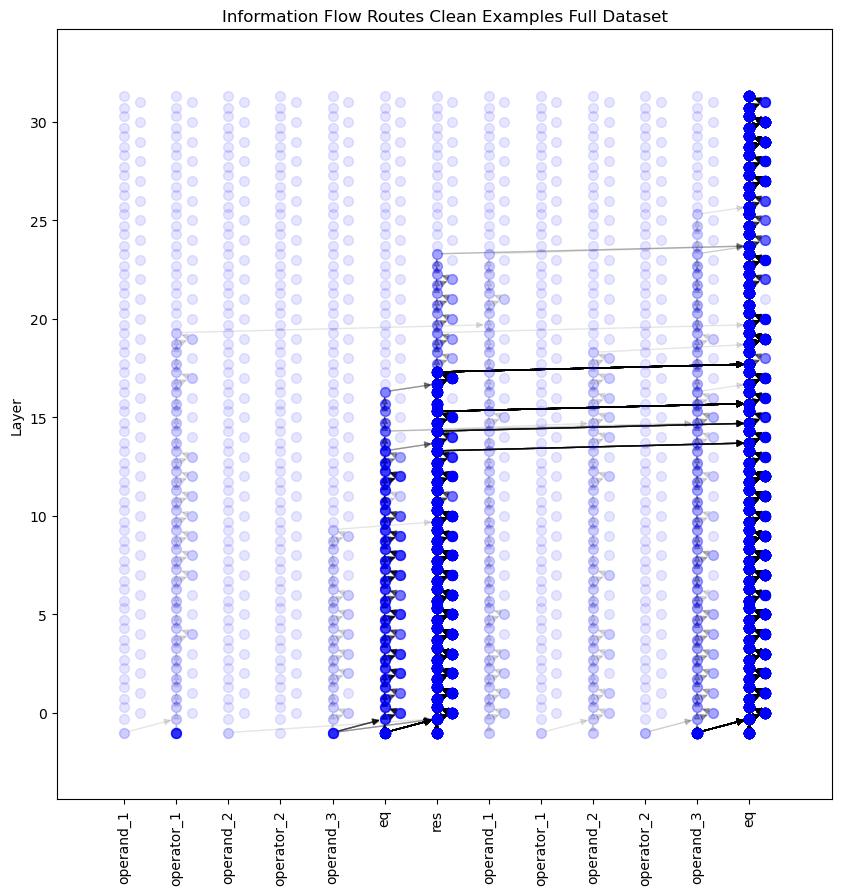

In [70]:
plot_all_graphs(contribution_graphs_operands_operators, LABELS, title='Information Flow Routes Clean Examples Full Dataset')

Contribution graphs for counterfactiual examples with random words instead of numbers

In [87]:
# threshold = 0.033
# contribution_graphs_counterfactual_alpha = compute_contribution_graphs(model_transparent, counterfactual_res_alpha, threshold)

In [72]:
# torch.save(contribution_graphs_counterfactual_alpha, '/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/information_flow_routes_results_opt_2_7b/contribution_graphs_counterfactual_symbol_result_opt_2_7.pkl')
contribution_graphs_counterfactual_alpha = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/information_flow_routes_results_opt_2_7b/contribution_graphs_counterfactual_symbol_result_opt_2_7.pkl')

/tmp/ipykernel_3197519/721149698.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  contribution_graphs_counterfactual_alpha = torch.load('/mnt/qb/work/eickhoff/esx208/arit

In [73]:
contribution_graphs_counterfactual_alpha_operands_operators = extract_operands_operators(contribution_graphs_counterfactual_alpha)

  0%|          | 0/210 [00:00<?, ?it/s]

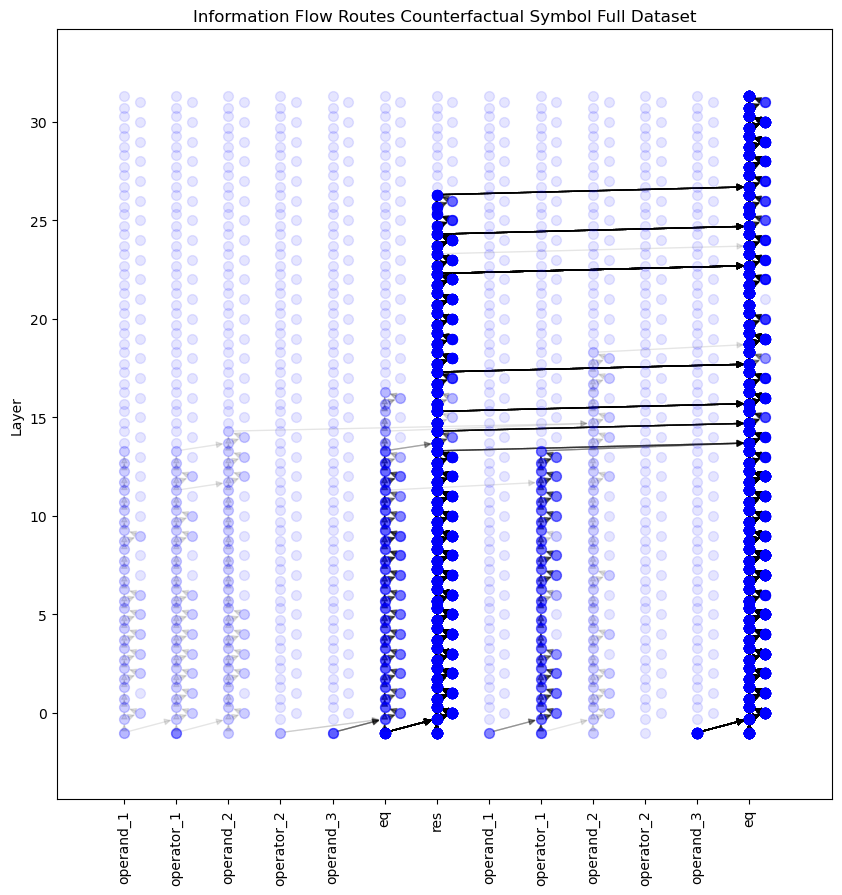

In [74]:
plot_all_graphs(contribution_graphs_counterfactual_alpha_operands_operators, LABELS, title='Information Flow Routes Counterfactual Symbol Full Dataset')

Contribution graphs for counterfactiual examples with textual forms of numbers

In [86]:
# threshold = 0.033
# contribution_graphs_counterfactual_words = compute_contribution_graphs(model_transparent, counterfactual_res_words, threshold)

In [83]:
# torch.save(contribution_graphs_counterfactual_words, '/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/information_flow_routes_results_opt_2_7b/contribution_graphs_counterfactual_word_result_opt_2_7.pkl')
contribution_graphs_counterfactual_words = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/information_flow_routes_results_opt_2_7b/contribution_graphs_counterfactual_word_result_opt_2_7.pkl')

In [84]:
contribution_graphs_counterfactual_words_operands_operators = extract_operands_operators(contribution_graphs_counterfactual_words)

  0%|          | 0/210 [00:00<?, ?it/s]

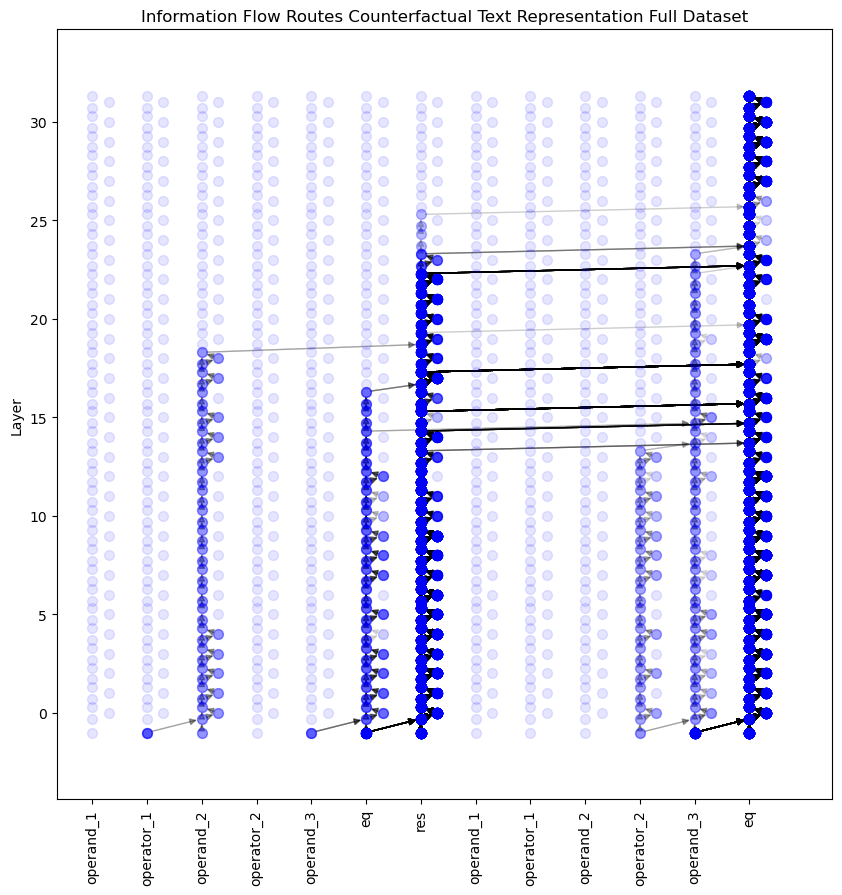

In [85]:
plot_all_graphs(contribution_graphs_counterfactual_words_operands_operators, LABELS, title='Information Flow Routes Counterfactual Text Representation Full Dataset')

Counterfactual experiments with random result

In [93]:
# threshold = 0.033
# contribution_graphs_counterfactual_random = compute_contribution_graphs(model_transparent, counterfactual_res_random, threshold)

In [92]:
# torch.save(contribution_graphs_counterfactual_random, '/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/information_flow_routes_results_opt_2_7b/contribution_graphs_counterfactual_arithmetically_incorrect_result_opt_2_7.pkl')
contributons_graphs_counterfactual_random = torch.load('/mnt/qb/work/eickhoff/esx208/arithmetic-lm/data/information_flow_routes_results_opt_2_7b/contribution_graphs_counterfactual_arithmetically_incorrect_result_opt_2_7.pkl')

/tmp/ipykernel_3197519/668678742.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  contributons_graphs_counterfactual_random = torch.load('/mnt/qb/work/eickhoff/esx208/ari

In [94]:
contribution_graphs_counterfactual_random_operands_operators = extract_operands_operators(contribution_graphs_counterfactual_random)

  0%|          | 0/210 [00:00<?, ?it/s]

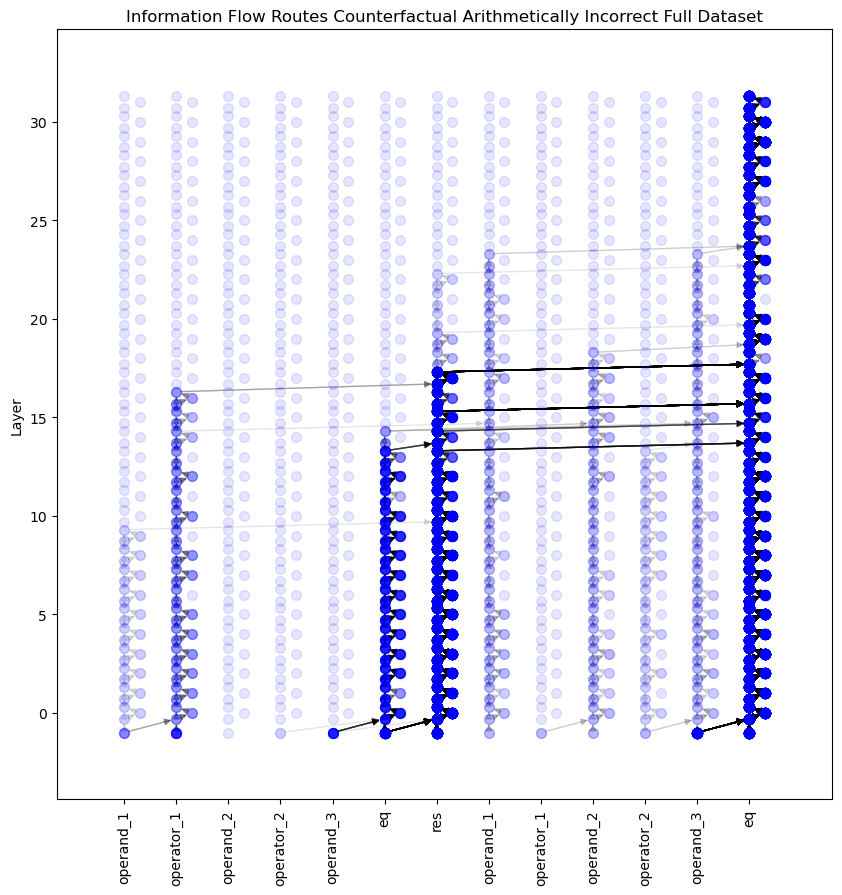

In [95]:
plot_all_graphs(contribution_graphs_counterfactual_random_operands_operators, LABELS, title='Information Flow Routes Counterfactual Arithmetically Incorrect Full Dataset')